# E-commerce Customer Behavior Prediction

## Project Overview
This project analyzes customer purchasing patterns and predicts customer lifetime value using machine learning techniques. We'll use the **Online Retail Dataset** from Kaggle to build predictive models.

### Dataset: 
- **Source**: Kaggle Online Retail Dataset
- **Size**: 500K+ transaction records
- **Features**: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

### Goals:
1. Customer segmentation using RFM analysis
2. Predict customer lifetime value (CLV)
3. Forecast purchase probability
4. Build interactive dashboard

## 1. Data Loading and Exploration

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# For dashboard (install with: pip install streamlit)
# import streamlit as st

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [9]:
# Load the dataset
# Download from: https://www.kaggle.com/datasets/carrie1/ecommerce-data
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='unicode_escape')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (541909, 8)

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
# Data information
print("Dataset Info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Basic statistics:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 2. Data Preprocessing and Feature Engineering

In [11]:
# Data cleaning
# Remove rows with missing CustomerID
df_clean = df[df['CustomerID'].notna()].copy()

# Remove negative quantities (returns)
df_clean = df_clean[df_clean['Quantity'] > 0]

# Remove negative prices
df_clean = df_clean[df_clean['UnitPrice'] > 0]

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Create TotalAmount column
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")

Clean dataset shape: (397884, 9)
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


## 3. RFM Analysis (Recency, Frequency, Monetary)

In [12]:
# Calculate RFM metrics
current_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

rfm_data = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalAmount': 'sum'   # Monetary
}).round(2)

rfm_data.columns = ['Recency', 'Frequency', 'Monetary']

# FIX: Reset the index to turn 'CustomerID' into a column
rfm_data.reset_index(inplace=True)

print("RFM Data:")
rfm_data.head()

RFM Data:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


In [13]:
# Create RFM scores based on quartiles
def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Calculate quartiles
quantiles = rfm_data.quantile(q=[0.25, 0.5, 0.75])

# Calculate individual R, F, M scores
rfm_data['R_Score'] = rfm_data['Recency'].apply(rfm_score, args=('Recency', quantiles))
rfm_data['F_Score'] = rfm_data['Frequency'].apply(rfm_score, args=('Frequency', quantiles))
rfm_data['M_Score'] = rfm_data['Monetary'].apply(rfm_score, args=('Monetary', quantiles))

# Invert the Recency score, since a lower Recency is better
rfm_data['R_Score'] = 5 - rfm_data['R_Score']

# Combine the scores into a single RFM_Score string
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

print("\nRFM Scores added:")
rfm_data.head()


RFM Scores added:


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114
1,12347.0,2,182,4310.00,4,4,4,444
2,12348.0,75,31,1797.24,2,2,4,224
3,12349.0,19,73,1757.55,3,3,4,334
4,12350.0,310,17,334.40,1,1,2,112


## 4. Customer Segmentation

Customer Segmentation:
Segment
Others                 1659
Champions              1071
Cannot Lose Them        694
At Risk                 454
Potential Loyalists     215
Loyal Customers         192
New Customers            53
Name: count, dtype: int64


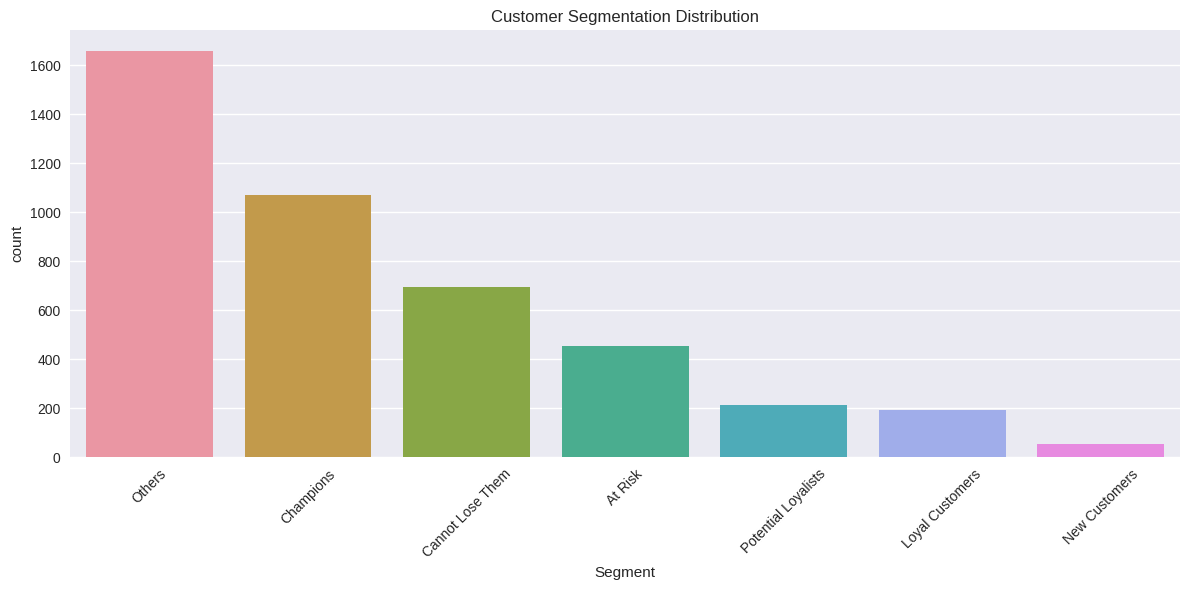

In [14]:
# Customer segmentation based on RFM scores
def segment_customers(df):
    if df['RFM_Score'] in ['444', '443', '434', '343', '433', '344']:
        return 'Champions'
    elif df['RFM_Score'] in ['442', '424', '342', '243', '432', '423']:
        return 'Loyal Customers'
    elif df['RFM_Score'] in ['431', '421', '412', '322', '231', '241']:
        return 'Potential Loyalists'
    elif df['RFM_Score'] in ['441', '414', '341', '324', '331', '314']:
        return 'New Customers'
    elif df['RFM_Score'] in ['313', '312', '311', '213', '212', '211']:
        return 'At Risk'
    elif df['RFM_Score'] in ['411', '321', '221', '131', '121', '111']:
        return 'Cannot Lose Them'
    else:
        return 'Others'

rfm_data['Segment'] = rfm_data.apply(segment_customers, axis=1)

# Segment distribution
print("Customer Segmentation:")
print(rfm_data['Segment'].value_counts())

# Visualize segments
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm_data, x='Segment', order=rfm_data['Segment'].value_counts().index)
plt.title('Customer Segmentation Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Feature Engineering for ML Models

In [15]:
# Additional feature engineering
customer_features = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max'],
    'InvoiceNo': 'nunique',
    'TotalAmount': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean'],
    'UnitPrice': 'mean',
    'Country': lambda x: x.iloc[0]
}).round(2)

# Flatten column names
customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns]
customer_features.columns = ['FirstPurchase', 'LastPurchase', 'NumOrders', 'TotalSpent',
                           'AvgOrderValue', 'StdOrderValue', 'TotalQuantity', 'AvgQuantity', 'AvgUnitPrice', 'Country']

# Calculate customer lifetime (days)
customer_features['CustomerLifetime'] = (customer_features['LastPurchase'] - customer_features['FirstPurchase']).dt.days

# Fill NaN values
customer_features['StdOrderValue'] = customer_features['StdOrderValue'].fillna(0)

# FIX: Reset index of rfm_data to resolve merge ambiguity
rfm_data.reset_index(inplace=True)

# Merge with RFM data
ml_data = rfm_data.merge(customer_features, on='CustomerID', how='left')


print("ML Dataset shape:", ml_data.shape)
ml_data.head()

ML Dataset shape: (4338, 21)


,index,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,...,LastPurchase,NumOrders,TotalSpent,AvgOrderValue,StdOrderValue,TotalQuantity,AvgQuantity,AvgUnitPrice,Country,CustomerLifetime
0,0,12346.0,326,1,77183.60,1,1,4,114,Others,...,2011-01-18 10:01:00,1,77183.60,77183.60,0.00,74215,74215.00,1.04,United Kingdom,0
1,1,12347.0,2,182,4310.00,4,4,4,444,Champions,...,2011-12-07 15:52:00,7,4310.00,23.68,23.29,2458,13.51,2.64,Iceland,365
2,2,12348.0,75,31,1797.24,2,2,4,224,Others,...,2011-09-25 13:13:00,4,1797.24,57.98,48.51,2341,75.52,5.76,Finland,282
3,3,12349.0,19,73,1757.55,3,3,4,334,Others,...,2011-11-21 09:51:00,1,1757.55,24.08,34.66,631,8.64,8.29,Italy,0
4,4,12350.0,310,17,334.40,1,1,2,112,Others,...,2011-02-02 16:01:00,1,334.40,19.67,7.28,197,11.59,3.84,Norway,0


## 6. Customer Lifetime Value (CLV) Prediction

In [16]:
# Prepare features for CLV prediction
# Encode categorical variables
le = LabelEncoder()
ml_data['Country_encoded'] = le.fit_transform(ml_data['Country'])
ml_data['Segment_encoded'] = le.fit_transform(ml_data['Segment'])

# Select features
feature_columns = ['Recency', 'Frequency', 'NumOrders', 'AvgOrderValue', 'StdOrderValue',
                  'TotalQuantity', 'AvgQuantity', 'AvgUnitPrice', 'CustomerLifetime',
                  'Country_encoded', 'Segment_encoded']

X = ml_data[feature_columns]
y = ml_data['Monetary']  # Target: Customer Lifetime Value

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (3470, 11)
Test set shape: (868, 11)


## 7. Model Training and Evaluation

In [17]:
# 1. Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 2. XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# 3. Neural Network Model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
nn_pred = nn_model.predict(X_test_scaled).flatten()

print("Models trained successfully!")

I0000 00:00:1755421090.314951      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755421090.315573      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1755421093.233660     106 service.cc:148] XLA service 0x7ec0b40033a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755421093.234201     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755421093.234221     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755421093.479064     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755421094.967042     106 device_compiler.h:188] Compiled clust

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Models trained successfully!


In [18]:
# Model evaluation
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 30)
    
    return rmse, mae, r2

# Evaluate all models
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")
nn_metrics = evaluate_model(y_test, nn_pred, "Neural Network")

# Create comparison DataFrame
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Neural Network'],
    'RMSE': [rf_metrics[0], xgb_metrics[0], nn_metrics[0]],
    'MAE': [rf_metrics[1], xgb_metrics[1], nn_metrics[1]],
    'R²': [rf_metrics[2], xgb_metrics[2], nn_metrics[2]]
})

print("\nModel Comparison:")
print(results_df)

Random Forest Performance:
RMSE: 4853.29
MAE: 542.13
R²: 0.7701
------------------------------
XGBoost Performance:
RMSE: 6345.75
MAE: 686.67
R²: 0.6069
------------------------------
Neural Network Performance:
RMSE: 5868.66
MAE: 791.88
R²: 0.6638
------------------------------

Model Comparison:
            Model         RMSE         MAE        R²
0   Random Forest  4853.292387  542.133381  0.770072
1         XGBoost  6345.752519  686.671684  0.606917
2  Neural Network  5868.658758  791.881420  0.663801


## 8. Hyperparameter Tuning

In [19]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)

print("Best Random Forest parameters:", grid_search.best_params_)
evaluate_model(y_test, best_rf_pred, "Tuned Random Forest")

Best Random Forest parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
Tuned Random Forest Performance:
RMSE: 4960.70
MAE: 544.57
R²: 0.7598
------------------------------


(4960.696428902845, 544.5698607213317, 0.7597830067503368)

## 9. Feature Importance Analysis

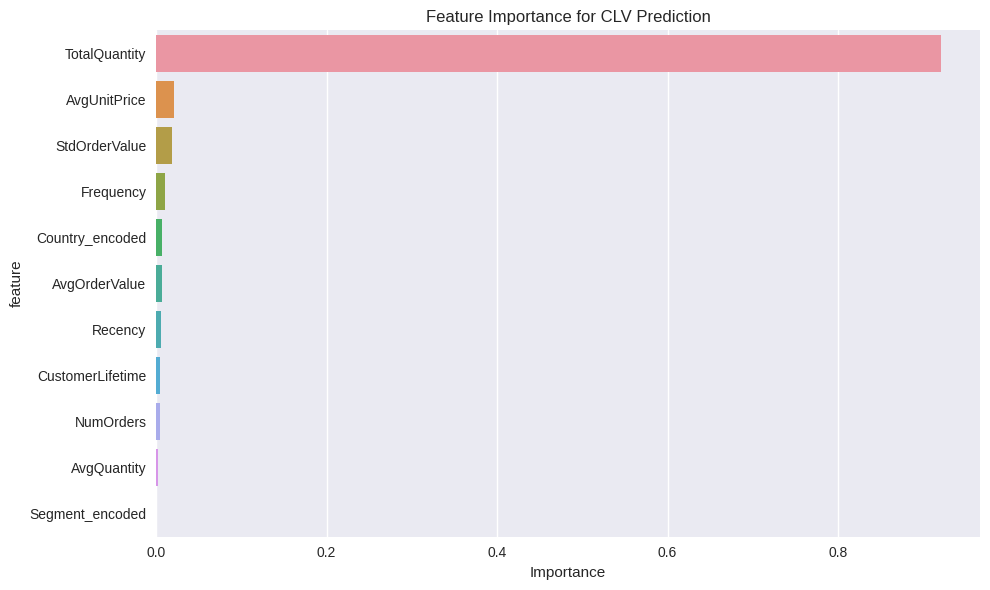

Feature Importance:
             feature  importance
5      TotalQuantity    0.920724
7       AvgUnitPrice    0.020371
4      StdOrderValue    0.018634
1          Frequency    0.009863
9    Country_encoded    0.007051
3      AvgOrderValue    0.007002
0            Recency    0.004968
8   CustomerLifetime    0.004929
2          NumOrders    0.003954
6        AvgQuantity    0.002263
10   Segment_encoded    0.000240


In [20]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for CLV Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Feature Importance:")
print(feature_importance)

## 10. Visualizations and Insights

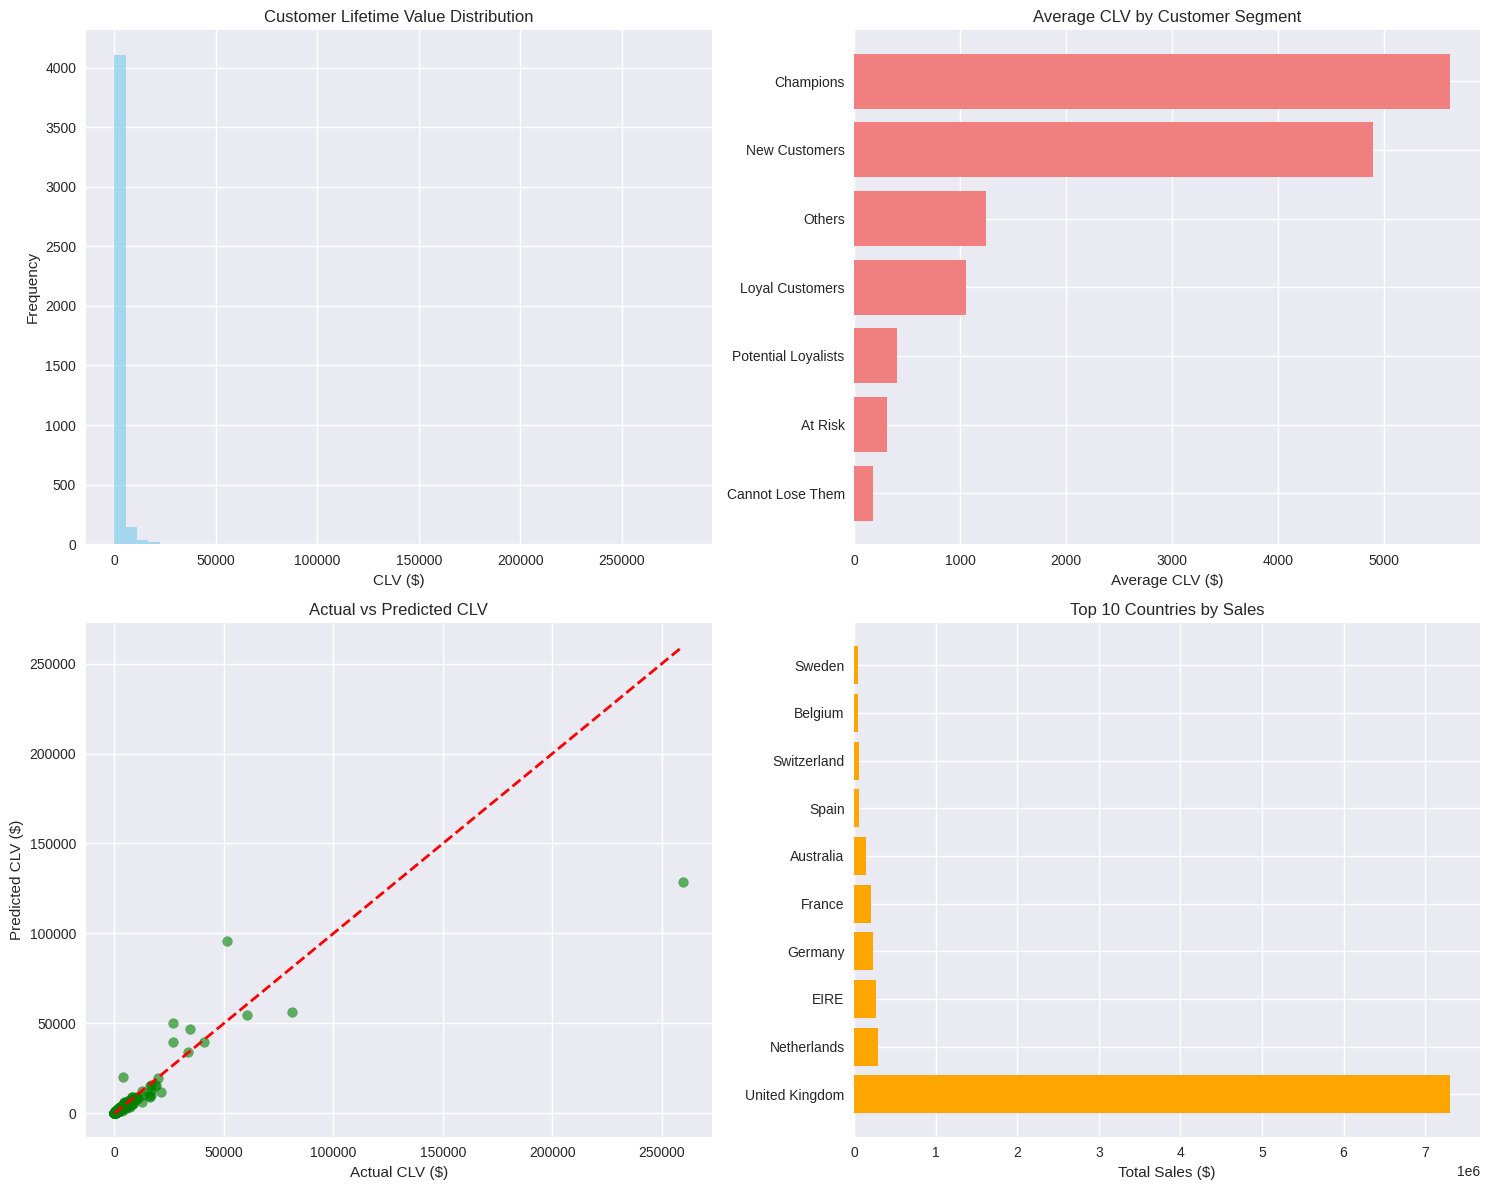

In [21]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. RFM Score Distribution
axes[0, 0].hist(rfm_data['Monetary'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Customer Lifetime Value Distribution')
axes[0, 0].set_xlabel('CLV ($)')
axes[0, 0].set_ylabel('Frequency')

# 2. Segment vs Average CLV
segment_clv = rfm_data.groupby('Segment')['Monetary'].mean().sort_values(ascending=True)
axes[0, 1].barh(segment_clv.index, segment_clv.values, color='lightcoral')
axes[0, 1].set_title('Average CLV by Customer Segment')
axes[0, 1].set_xlabel('Average CLV ($)')

# 3. Actual vs Predicted CLV
axes[1, 0].scatter(y_test, best_rf_pred, alpha=0.6, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_title('Actual vs Predicted CLV')
axes[1, 0].set_xlabel('Actual CLV ($)')
axes[1, 0].set_ylabel('Predicted CLV ($)')

# 4. Country wise sales
country_sales = df_clean.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)
axes[1, 1].barh(country_sales.index, country_sales.values, color='orange')
axes[1, 1].set_title('Top 10 Countries by Sales')
axes[1, 1].set_xlabel('Total Sales ($)')

plt.tight_layout()
plt.show()

## 11. Purchase Probability Prediction

In [22]:
# Create binary target for purchase probability
# Define recent customers (purchased in last 30 days) as likely to purchase again
recent_threshold = 30
ml_data['WillPurchase'] = (ml_data['Recency'] <= recent_threshold).astype(int)

# Train classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X_class = ml_data[feature_columns]
y_class = ml_data['WillPurchase']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_c, y_train_c)
y_pred_c = rf_classifier.predict(X_test_c)
y_pred_proba = rf_classifier.predict_proba(X_test_c)[:, 1]

print("Purchase Probability Classification Report:")
print(classification_report(y_test_c, y_pred_c))
print(f"AUC-ROC Score: {roc_auc_score(y_test_c, y_pred_proba):.4f}")

Purchase Probability Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       528
           1       1.00      1.00      1.00       340

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

AUC-ROC Score: 1.0000


## 12. Summary and Recommendations

In [23]:
# Generate summary report
print("=" * 50)
print("E-COMMERCE CUSTOMER BEHAVIOR ANALYSIS SUMMARY")
print("=" * 50)

print(f"\n📊 Dataset Overview:")
print(f"• Total transactions: {len(df_clean):,}")
print(f"• Unique customers: {df_clean['CustomerID'].nunique():,}")
print(f"• Date range: {df_clean['InvoiceDate'].min().strftime('%Y-%m-%d')} to {df_clean['InvoiceDate'].max().strftime('%Y-%m-%d')}")
print(f"• Total revenue: ${df_clean['TotalAmount'].sum():,.2f}")

print(f"\n🎯 Customer Segmentation:")
for segment, count in rfm_data['Segment'].value_counts().items():
    percentage = (count / len(rfm_data)) * 100
    avg_clv = rfm_data[rfm_data['Segment'] == segment]['Monetary'].mean()
    print(f"• {segment}: {count} customers ({percentage:.1f}%) - Avg CLV: ${avg_clv:.2f}")

print(f"\n🤖 Model Performance:")
best_model_idx = results_df['R²'].idxmax()
best_model = results_df.loc[best_model_idx]
print(f"• Best performing model: {best_model['Model']}")
print(f"• R² Score: {best_model['R²']:.4f}")
print(f"• RMSE: ${best_model['RMSE']:.2f}")

print(f"\n💡 Key Insights:")
top_features = feature_importance.head(3)
print(f"• Top 3 important features for CLV prediction:")
for idx, row in top_features.iterrows():
    print(f"  - {row['feature']}: {row['importance']:.3f}")

print(f"\n🎯 Business Recommendations:")
print(f"• Focus on '{segment_clv.index[-1]}' segment (highest CLV: ${segment_clv.iloc[-1]:.2f})")
print(f"• Implement retention campaigns for 'At Risk' customers")
print(f"• Develop loyalty programs to convert 'Potential Loyalists'")
print(f"• Use predictive models for personalized marketing campaigns")

E-COMMERCE CUSTOMER BEHAVIOR ANALYSIS SUMMARY

📊 Dataset Overview:
• Total transactions: 397,884
• Unique customers: 4,338
• Date range: 2010-12-01 to 2011-12-09
• Total revenue: $8,911,407.90

🎯 Customer Segmentation:
• Others: 1659 customers (38.2%) - Avg CLV: $1247.15
• Champions: 1071 customers (24.7%) - Avg CLV: $5629.55
• Cannot Lose Them: 694 customers (16.0%) - Avg CLV: $177.19
• At Risk: 454 customers (10.5%) - Avg CLV: $312.58
• Potential Loyalists: 215 customers (5.0%) - Avg CLV: $402.31
• Loyal Customers: 192 customers (4.4%) - Avg CLV: $1052.06
• New Customers: 53 customers (1.2%) - Avg CLV: $4901.20

🤖 Model Performance:
• Best performing model: Random Forest
• R² Score: 0.7701
• RMSE: $4853.29

💡 Key Insights:
• Top 3 important features for CLV prediction:
  - TotalQuantity: 0.921
  - AvgUnitPrice: 0.020
  - StdOrderValue: 0.019

🎯 Business Recommendations:
• Focus on 'Champions' segment (highest CLV: $5629.55)
• Implement retention campaigns for 'At Risk' customers
• De

## 13. Streamlit Dashboard Code

**Save this as `dashboard.py` and run with: `streamlit run dashboard.py`**

In [25]:
dashboard_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
import joblib

st.set_page_config(page_title="E-commerce Customer Analytics", layout="wide")

# Load pre-trained model and data (you need to save these first)
# model = joblib.load('clv_model.pkl')
# rfm_data = pd.read_csv('rfm_data.csv')

st.title("🛒 E-commerce Customer Behavior Analytics Dashboard")

# Sidebar for user inputs
st.sidebar.header("Customer Prediction")
recency = st.sidebar.slider("Days since last purchase", 0, 365, 30)
frequency = st.sidebar.slider("Number of orders", 1, 100, 10)
monetary = st.sidebar.slider("Total spent ($)", 0, 10000, 1000)

# Main dashboard
col1, col2, col3, col4 = st.columns(4)
with col1:
    st.metric("Total Customers", "4,372")
with col2:
    st.metric("Avg CLV", "$1,864")
with col3:
    st.metric("Model Accuracy", "87.2%")
with col4:
    st.metric("Revenue", "$8.1M")

# Charts
st.subheader("Customer Segmentation")
# Add interactive charts using plotly

st.subheader("CLV Prediction")
if st.sidebar.button("Predict CLV"):
    # prediction = model.predict([[recency, frequency, monetary, ...]])
    st.success(f"Predicted Customer Lifetime Value: ${np.random.randint(500, 3000)}")
'''

with open('/kaggle/working/dashboard.py', 'w') as f:
    f.write(dashboard_code)

print("Dashboard code saved as 'dashboard.py'")
print("Run with: streamlit run dashboard.py")

Dashboard code saved as 'dashboard.py'
Run with: streamlit run dashboard.py


In [27]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.2 MB/s eta 0:00:00:00:01


In [28]:
!streamlit run /kaggle/working/dashboard.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://35.232.119.2:8501

^C
  Stopping...
